In [1]:
import scipy
import scipy.io
from scipy.io import wavfile
import matplotlib.pyplot as plt
import librosa
import numpy as np
import numexpr as ne

In [2]:
sample_rate, signal = wavfile.read('apple.wav')

In [3]:
signal = signal.astype('float')

In [4]:
sample_rate, signal

(8000, array([ 102.,  151.,   82., ..., -471., -192.,  237.]))

# Original

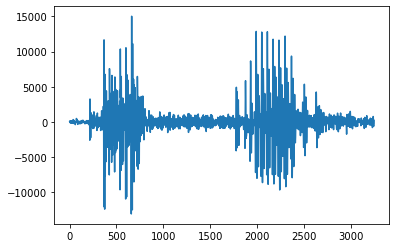

In [5]:
plt.plot(signal)
plt.show()

# Pre-emphasis

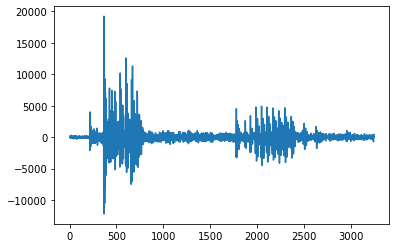

In [6]:
emphasis_signal = librosa.effects.preemphasis(signal, coef=0.95)
plt.plot(emphasis_signal)
plt.show()

# Block into frames

In [7]:
N = 360 # 45ms
M = 120 # 15ms

In [8]:
frames = librosa.util.frame(signal, N, M)
frames.shape

(360, 25)

# Window frame

In [9]:
frame_windowed = (frames.T * np.hamming(N)).T
frame_windowed.shape

(360, 25)

# Auto correlation

In [10]:
p = 8
autocorrelation_signal = librosa.core.autocorrelate(frame_windowed, axis=0, max_size=p + 1)
autocorrelation_signal.shape

(9, 25)

# LPC/Ceptral Analysis

In [11]:
lpc_signal = np.array([librosa.core.lpc(autocorrelation_signal[:, i], order=p) for i in range(autocorrelation_signal.shape[1])])
lpc_signal = lpc_signal.T
lpc_signal.shape

C:\Users\nvatu\anaconda3\lib\site-packages\librosa\core\audio.py:932: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 1d, A), array(float64, 1d, A))
  den = np.dot(fwd_pred_error, fwd_pred_error) + np.dot(
C:\Users\nvatu\anaconda3\lib\site-packages\librosa\core\audio.py:943: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 1d, A), array(float64, 1d, A))
  reflect_coeff = dtype(-2) * np.dot(bwd_pred_error, fwd_pred_error) / dtype(den)


(9, 25)

# Cepstral Weighting

In [12]:
def cepstral_weighting_window(m):
    pi = np.pi
    Q = p
    return ne.evaluate('1 + Q/2 * sin(pi*m/Q)')

In [13]:
m = np.arange(p + 1)
cepstral_weighting = (lpc_signal.T * cepstral_weighting_window(m)).T
cepstral_weighting.shape

(9, 25)

# Delta cepstrum

In [14]:
G = 0.375

In [15]:
cepstral_weighting.shape[1]

25

In [16]:
cepstral_weighting[0]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1.])

In [17]:
k = 2
delta_cepstrum = librosa.feature.delta(cepstral_weighting, width=2 * k + 1)
delta_cepstrum.shape

(9, 25)

# Observation

In [18]:
observation = np.concatenate((cepstral_weighting, delta_cepstrum))
observation.shape

(18, 25)

# Train HMM

In [19]:
from hmmlearn import hmm

In [20]:
observation = observation.T
observation.shape

(25, 18)

In [33]:
model = hmm.GaussianHMM(n_components=5, verbose=True)
model.fit(observation)

         1        -761.1201             +nan
         2        -554.2207        +206.8994
         3        -523.0513         +31.1694
         4        -523.0449          +0.0064


GaussianHMM(n_components=5, verbose=True)

In [34]:
ll, hidden = model.decode(observation)
np.exp(ll)

6.988911686922876e-228

In [29]:
hidden

array([4, 4, 4, 4, 4, 3, 0, 0, 4, 0, 0, 0, 4, 4, 3, 1, 0, 1, 1, 3, 3, 3,
       2, 3, 2])